In [1]:
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

In [2]:
MAIN_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/' # Directory where this .ipynb file sits

DATA_PATH = Path(MAIN_DIR + '/bert_data/') # Need to create directory beforehand
LABEL_PATH = Path(MAIN_DIR + '/bert_data/') # Need labels.csv (see https://github.com/kaushaltrivedi/fast-bert how to format)

AUG_DATA_PATH = Path(MAIN_DIR + '/bert_models/data_augmentation/') # Need to create directory beforehand
MODEL_PATH=Path(MAIN_DIR + '/bert_models/models/') # Need to create directory beforehand
LOG_PATH=Path(MAIN_DIR + '/bert_models/logs/') # Need to create directory beforehand
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/cased_L-12_H-768_A-12/')
BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../bert_fastai/pretrained-weights/uncased_L-24_H-1024_A-16/')
# FINETUNED_PATH = Path('../models/finetuned_model.bin')
FINETUNED_PATH = None
# model_state_dict = torch.load(FINETUNED_PATH)

LOG_PATH.mkdir(exist_ok=True)

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

## Transforming Data into format that the model uses

In [3]:
train_data = pd.read_csv(MAIN_DIR + 'profile_data_train.csv')

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

bert_data_train = pd.concat([train_data,pd.get_dummies(train_data['age_group'], prefix='age_group')],axis=1)
bert_data_train.drop(['age_group'],axis=1, inplace=True)

drop_columns = ['handle', 'followers', 'following', 'follower_following_ratio', 'avg_favorites', 'min_favorites', 'max_favorites', 'avg_retweets', 'min_retweets', 'max_retweets', 'hashtags',
                'hashtags_per_tweet', 'mentions_per_tweet', 'avg_timedelta_hrs', 'avg_word_count']

bert_data_train.drop(drop_columns,axis=1, inplace=True)

bert_data_train.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']

bert_data_train.to_csv(str(DATA_PATH) + '/train.csv', index = False) # Uncomment first time you run

###############################################################################################################################################################################################################

bert_data_val = pd.concat([val_data,pd.get_dummies(val_data['age_group'], prefix='age_group')],axis=1)
bert_data_val.drop(['age_group'],axis=1, inplace=True)

bert_data_val.drop(drop_columns,axis=1, inplace=True)

bert_data_val.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']

bert_data_val.to_csv(str(DATA_PATH) + '/val.csv', index = False) # Uncomment first time you run

###############################################################################################################################################################################################################

test_data = pd.read_csv(MAIN_DIR + 'profile_data_test.csv')

bert_data = pd.concat([test_data,pd.get_dummies(test_data['age_group'], prefix='age_group')],axis=1)
bert_data.drop(['age_group'],axis=1, inplace=True)

bert_data.drop(drop_columns,axis=1, inplace=True)

bert_data.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']

bert_data.to_csv(str(DATA_PATH) + '/test.csv', index = False) # Uncomment first time you run

In [4]:
torch.cuda.empty_cache()

In [5]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Model Parameters
#### May need to adjust based on your system capabilities
I had to reduce "max_seq_lenth" and "batch_size" because I ran out of memory

In [6]:
args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "toxic_classification_lib",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 128,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 4,
    "eval_batch_size": 8,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'xlnet-base-cased',
    "model_type": 'xlnet',
    "multi_gpu": False
})

In [7]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [8]:
logger.info(args)

04/30/2020 19:38:30 - INFO - root -   {'run_text': 'multilabel toxic comments with freezable layers', 'train_size': -1, 'val_size': -1, 'log_path': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/logs'), 'full_data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'task_name': 'intent', 'no_cuda': False, 'bert_model': WindowsPath('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12'), 'output_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/models/output'), 'max_seq_length': 128, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 4, 'eval_batch_size': 8, 'learning_rate': 5e-05, 'num_train_epochs': 6, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': True,

In [9]:
# tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [10]:
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [11]:
label_cols = ['age_group_0','age_group_1','age_group_2','age_group_3']

## Transforming Text to Bert Data

In [12]:
databunch = BertDataBunch(DATA_PATH, LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="text", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

04/30/2020 19:38:30 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
04/30/2020 19:38:30 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,

In [13]:
num_labels = len(databunch.labels)
num_labels

4

In [14]:
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})

## Defining the Learner

In [15]:
learner = BertLearner.from_pretrained_model(databunch, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=False, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)



04/30/2020 19:38:30 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
04/30/2020 19:38:30 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "_num_labels": 4,
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "mem_len": 

## Fitting the Model

In [16]:
learner.fit(args.num_train_epochs, args.learning_rate, validate=True)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
04/30/2020 19:38:34 - INFO - root -   ***** Running training *****
04/30/2020 19:38:34 - INFO - root -     Num examples = 1529
04/30/2020 19:38:34 - INFO - root -     Num Epochs = 6
04/30/2020 19:38:34 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
04/30/2020 19:38:34 - 

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
04/30/2020 19:40:34 - INFO - root -   Running evaluation
04/30/2020 19:40:34 - INFO - root -     Num examples = 170
04/30/2020 19:40:34 - INFO - root -     Batch size = 8


04/30/2020 19:40:35 - INFO - root -   eval_loss after epoch 1: 0.5285136266188188: 
04/30/2020 19:40:35 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.7514706254005432: 
04/30/2020 19:40:35 - INFO - root -   eval_roc_auc after epoch 1: 0.6549711649365628: 
04/30/2020 19:40:35 - INFO - root -   eval_fbeta after epoch 1: 0.2847338914871216: 
04/30/2020 19:40:35 - INFO - root -   lr after epoch 1: 3.83e-05
04/30/2020 19:40:35 - INFO - root -   train_loss after epoch 1: 0.6324651970408915
04/30/2020 19:40:35 - INFO - root -   



c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


04/30/2020 19:42:37 - INFO - root -   Running evaluation
04/30/2020 19:42:37 - INFO - root -     Num examples = 170
04/30/2020 19:42:37 - INFO - root -     Batch size = 8


04/30/2020 19:42:38 - INFO - root -   eval_loss after epoch 2: 0.47756458006121894: 
04/30/2020 19:42:38 - INFO - root -   eval_accuracy_thresh after epoch 2: 0.7750000357627869: 
04/30/2020 19:42:38 - INFO - root -   eval_roc_auc after epoch 2: 0.7434544405997694: 
04/30/2020 19:42:38 - INFO - root -   eval_fbeta after epoch 2: 0.5180672407150269: 
04/30/2020 19:42:38 - INFO - root -   lr after epoch 2: 4.734807219661191e-05
04/30/2020 19:42:38 - INFO - root -   train_loss after epoch 2: 0.5155726742028568
04/30/2020 19:42:38 - INFO - root -   

04/30/2020 19:44:41 - INFO - root -   Running evaluation
04/30/2020 19:44:41 - INFO - root -     Num examples = 170
04/30/2020 19:44:41 - INFO - root -     Batch size = 8


04/30/2020 19:44:42 - INFO - root -   eval_loss after epoch 3: 0.46552335809577594: 
04/30/2020 19:44:42 - INFO - root -   eval_accuracy_thresh after epoch 3: 0.7779411673545837: 
04/30/2020 19:44:42 - INFO - root -   eval_roc_auc after epoch 3: 0.7538235294117647: 
04/30/2020 19:44:42 - INFO - root -   eval_fbeta after epoch 3: 0.5726891160011292: 
04/30/2020 19:44:42 - INFO - root -   lr after epoch 3: 3.5576452277873776e-05
04/30/2020 19:44:42 - INFO - root -   train_loss after epoch 3: 0.47899890179422444
04/30/2020 19:44:42 - INFO - root -   

04/30/2020 19:46:45 - INFO - root -   Running evaluation
04/30/2020 19:46:45 - INFO - root -     Num examples = 170
04/30/2020 19:46:45 - INFO - root -     Batch size = 8


04/30/2020 19:46:46 - INFO - root -   eval_loss after epoch 4: 0.46706958656961267: 
04/30/2020 19:46:46 - INFO - root -   eval_accuracy_thresh after epoch 4: 0.779411792755127: 
04/30/2020 19:46:46 - INFO - root -   eval_roc_auc after epoch 4: 0.7581487889273357: 
04/30/2020 19:46:46 - INFO - root -   eval_fbeta after epoch 4: 0.5441176295280457: 
04/30/2020 19:46:46 - INFO - root -   lr after epoch 4: 1.92424747032817e-05
04/30/2020 19:46:46 - INFO - root -   train_loss after epoch 4: 0.4615488487731072
04/30/2020 19:46:46 - INFO - root -   

04/30/2020 19:48:48 - INFO - root -   Running evaluation
04/30/2020 19:48:48 - INFO - root -     Num examples = 170
04/30/2020 19:48:48 - INFO - root -     Batch size = 8


04/30/2020 19:48:50 - INFO - root -   eval_loss after epoch 5: 0.46103901077400555: 
04/30/2020 19:48:50 - INFO - root -   eval_accuracy_thresh after epoch 5: 0.7823529839515686: 
04/30/2020 19:48:50 - INFO - root -   eval_roc_auc after epoch 5: 0.7657093425605537: 
04/30/2020 19:48:50 - INFO - root -   eval_fbeta after epoch 5: 0.5759103894233704: 
04/30/2020 19:48:50 - INFO - root -   lr after epoch 5: 5.392117243083616e-06
04/30/2020 19:48:50 - INFO - root -   train_loss after epoch 5: 0.4505725329834238
04/30/2020 19:48:50 - INFO - root -   

04/30/2020 19:50:52 - INFO - root -   Running evaluation
04/30/2020 19:50:52 - INFO - root -     Num examples = 170
04/30/2020 19:50:52 - INFO - root -     Batch size = 8


04/30/2020 19:50:54 - INFO - root -   eval_loss after epoch 6: 0.46160322427749634: 
04/30/2020 19:50:54 - INFO - root -   eval_accuracy_thresh after epoch 6: 0.7852941155433655: 
04/30/2020 19:50:54 - INFO - root -   eval_roc_auc after epoch 6: 0.7657439446366782: 
04/30/2020 19:50:54 - INFO - root -   eval_fbeta after epoch 6: 0.5834734439849854: 
04/30/2020 19:50:54 - INFO - root -   lr after epoch 6: 0.0
04/30/2020 19:50:54 - INFO - root -   train_loss after epoch 6: 0.4471606486148685
04/30/2020 19:50:54 - INFO - root -   



(2298, 0.49771980056822873)

In [17]:
learner.validate()

04/30/2020 19:50:54 - INFO - root -   Running evaluation
04/30/2020 19:50:54 - INFO - root -     Num examples = 170
04/30/2020 19:50:54 - INFO - root -     Batch size = 8


{'loss': 0.46160322427749634,
 'accuracy_thresh': 0.7852941155433655,
 'roc_auc': 0.7657439446366782,
 'fbeta': 0.5834734439849854}

In [18]:
learner.save_model()

04/30/2020 19:50:55 - INFO - transformers.configuration_utils -   Configuration saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\config.json
04/30/2020 19:50:55 - INFO - transformers.modeling_utils -   Model weights saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\pytorch_model.bin


## Predicting the Test Set

In [19]:
predictions = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/test.csv')['text'].values))

04/30/2020 19:50:55 - INFO - root -   Writing example 0 of 425


#### Arg maxing for prediction label
predictions sort based on which category gave the highest prediction

In [20]:
label_pred = []
for pred in predictions:
    if pred[0][0] == 'age_group_0':
        label_pred.append(0)
    elif pred[0][0] == 'age_group_1':
        label_pred.append(1)
    elif pred[0][0] == 'age_group_2':
        label_pred.append(2)
    elif pred[0][0] == 'age_group_3':
        label_pred.append(3)

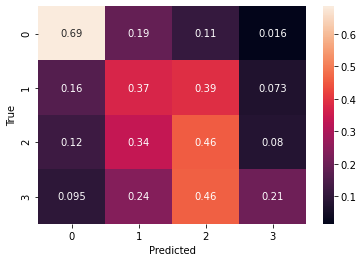

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Metadata Model

In [22]:
import xgboost as xgb

In [23]:
train_data_meta = train_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)
val_data_meta = val_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

In [24]:
meta_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

In [25]:
meta_model.fit(train_data_meta.drop('age_group', axis=1), train_data_meta['age_group'], eval_set=[(val_data_meta.drop('age_group', axis=1), val_data_meta['age_group'])], early_stopping_rounds=10)

[0]	validation_0-merror:0.50588
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.50588
[2]	validation_0-merror:0.50000
[3]	validation_0-merror:0.49412
[4]	validation_0-merror:0.50000
[5]	validation_0-merror:0.48823
[6]	validation_0-merror:0.48235
[7]	validation_0-merror:0.50000
[8]	validation_0-merror:0.47647
[9]	validation_0-merror:0.48235
[10]	validation_0-merror:0.48235
[11]	validation_0-merror:0.49412
[12]	validation_0-merror:0.47647
[13]	validation_0-merror:0.48235
[14]	validation_0-merror:0.48235
[15]	validation_0-merror:0.48823
[16]	validation_0-merror:0.48823
[17]	validation_0-merror:0.48235
[18]	validation_0-merror:0.47647
Stopping. Best iteration:
[8]	validation_0-merror:0.47647



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [26]:
test_data_meta = test_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

In [27]:
label_pred = meta_model.predict(test_data_meta.drop('age_group', axis=1))

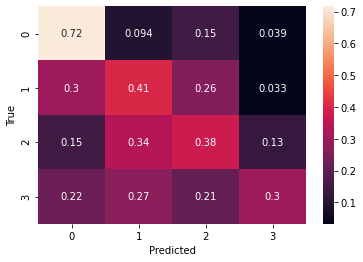

In [28]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Emsembling the two models

In [29]:
bert_pred_train = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/train.csv')['text'].values))
bert_pred_val = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/val.csv')['text'].values))

04/30/2020 19:51:00 - INFO - root -   Writing example 0 of 1529
04/30/2020 19:51:15 - INFO - root -   Writing example 0 of 170


In [30]:
meta_pred_train = meta_model.predict_proba(train_data_meta.drop('age_group', axis=1))
meta_pred_val = meta_model.predict_proba(val_data_meta.drop('age_group', axis=1))

In [31]:
combined_pred_train = []
combined_pred_val = []
count = 0
for pred in bert_pred_train:
    combined_pred_train.append([0,0,0,0,0,0,0,0])
    combined_pred_train[count][0] = meta_pred_train[count][0]
    combined_pred_train[count][1] = meta_pred_train[count][1]
    combined_pred_train[count][2] = meta_pred_train[count][2]
    combined_pred_train[count][3] = meta_pred_train[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred_train[count][4] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred_train[count][5] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred_train[count][6] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred_train[count][7] = pred[i][1]
    count += 1
    
count = 0
for pred in bert_pred_val:
    combined_pred_val.append([0,0,0,0,0,0,0,0])
    combined_pred_val[count][0] = meta_pred_train[count][0]
    combined_pred_val[count][1] = meta_pred_train[count][1]
    combined_pred_val[count][2] = meta_pred_train[count][2]
    combined_pred_val[count][3] = meta_pred_train[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred_val[count][4] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred_val[count][5] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred_val[count][6] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred_val[count][7] = pred[i][1]
    count += 1

In [32]:
ensemble_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

In [33]:
combined_pred_train = pd.DataFrame(combined_pred_train)
combined_pred_val = pd.DataFrame(combined_pred_val)

In [34]:
ensemble_model.fit(combined_pred_train, train_data['age_group'], eval_set=[(combined_pred_val, val_data['age_group'])], early_stopping_rounds=10)

[0]	validation_0-merror:0.70588
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.70588
[2]	validation_0-merror:0.69412
[3]	validation_0-merror:0.70000
[4]	validation_0-merror:0.69412
[5]	validation_0-merror:0.68824
[6]	validation_0-merror:0.69412
[7]	validation_0-merror:0.68824
[8]	validation_0-merror:0.68824
[9]	validation_0-merror:0.68824
[10]	validation_0-merror:0.68824
[11]	validation_0-merror:0.69412
[12]	validation_0-merror:0.69412
[13]	validation_0-merror:0.69412
[14]	validation_0-merror:0.68824
[15]	validation_0-merror:0.68824
Stopping. Best iteration:
[5]	validation_0-merror:0.68824



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [35]:
meta_pred = meta_model.predict_proba(test_data_meta.drop('age_group', axis=1))
combined_pred = []

count = 0
for pred in predictions:
    combined_pred.append([0,0,0,0,0,0,0,0])
    combined_pred[count][0] = meta_pred[count][0]
    combined_pred[count][1] = meta_pred[count][1]
    combined_pred[count][2] = meta_pred[count][2]
    combined_pred[count][3] = meta_pred[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred[count][4] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred[count][5] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred[count][6] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred[count][7] = pred[i][1]
    count += 1

combined_pred = pd.DataFrame(combined_pred)

In [36]:
label_pred = ensemble_model.predict(combined_pred)

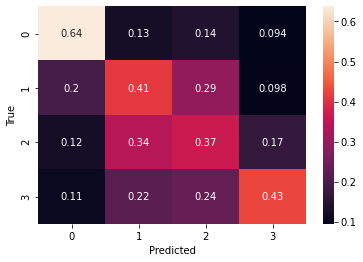

In [37]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()